<a href="https://colab.research.google.com/github/Ravenn97/new_project/blob/master/solarproduct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn import preprocessing
import pandas as pd
!pip3 install xlrd
!pip3 install seaborn
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
from scipy.stats import skew,norm
from scipy.stats.stats import pearsonr


In [0]:
data = pd.read_excel("PV.xlsx")

In [3]:
data.head()

,Time,Irradiation[kW/m2],Temperture[℃],PV Generation[kW]
0,2015-01-01 00:00:00,0.0,2.76,0.0
1,2015-01-01 00:01:00,0.0,2.78,0.0
2,2015-01-01 00:02:00,0.0,2.81,0.0
3,2015-01-01 00:03:00,0.0,2.86,0.0
4,2015-01-01 00:04:00,0.0,2.91,0.0


In [4]:

len(data)

525600

## Rename of feature

In [0]:
data_copy = data.copy()

In [6]:
features = ["time", "irr", "temp", "generation"]
data_copy.columns = features
data_copy.head()

,time,irr,temp,generation
0,2015-01-01 00:00:00,0.0,2.76,0.0
1,2015-01-01 00:01:00,0.0,2.78,0.0
2,2015-01-01 00:02:00,0.0,2.81,0.0
3,2015-01-01 00:03:00,0.0,2.86,0.0
4,2015-01-01 00:04:00,0.0,2.91,0.0


## Pre-process data

### Remove outlier 

In [0]:
#remove all of row which 'irr' feature or 'generation' = '0'
data_copy = data_copy[data_copy["irr"] != 0]
data_copy = data_copy[data_copy["generation"] != 0]


In [8]:
data_copy.head()

,time,irr,temp,generation
420,2015-01-01 07:00:00,0.01,-2.52,7.61
421,2015-01-01 07:01:00,0.01,-2.52,8.73
422,2015-01-01 07:02:00,0.01,-2.52,9.63
423,2015-01-01 07:03:00,0.01,-2.53,10.59
424,2015-01-01 07:04:00,0.01,-2.53,11.75


### Trans the datetime() type to float() type and drop "year" feature

In [0]:
#this function will generated 'year', 'moth', 'day','hour', 'minute' and remove 'time' feature
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Tt]ime$', '', fldname)
    attr = ['year', 'month', 'week', 'day']
    if time: attr = attr + ['hour', 'minute', 'second']
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: 
        df.drop(fldname, axis=1, inplace=True)

In [0]:
add_datepart(data_copy, 'time',drop=True, time=True)


In [0]:
data_copy = data_copy.drop('year', axis = 1) #drop 'year' feature

In [12]:
data_copy.head()

,irr,temp,generation,month,week,day,hour,minute,second
420,0.01,-2.52,7.61,1,1,1,7,0,0
421,0.01,-2.52,8.73,1,1,1,7,1,0
422,0.01,-2.52,9.63,1,1,1,7,2,0
423,0.01,-2.53,10.59,1,1,1,7,3,0
424,0.01,-2.53,11.75,1,1,1,7,4,0


In [13]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253344 entries, 420 to 525135
Data columns (total 9 columns):
irr           253328 non-null float64
temp          253328 non-null float64
generation    252526 non-null float64
month         253344 non-null int64
week          253344 non-null int64
day           253344 non-null int64
hour          253344 non-null int64
minute        253344 non-null int64
second        253344 non-null int64
dtypes: float64(3), int64(6)
memory usage: 19.3 MB


### Fix missing value by remove column

In [14]:
data_copy= data_copy.dropna(axis=0)
data_copy.info()
data_copy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252510 entries, 420 to 525135
Data columns (total 9 columns):
irr           252510 non-null float64
temp          252510 non-null float64
generation    252510 non-null float64
month         252510 non-null int64
week          252510 non-null int64
day           252510 non-null int64
hour          252510 non-null int64
minute        252510 non-null int64
second        252510 non-null int64
dtypes: float64(3), int64(6)
memory usage: 19.3 MB


,irr,temp,generation,month,week,day,hour,minute,second
420,0.01,-2.52,7.61,1,1,1,7,0,0
421,0.01,-2.52,8.73,1,1,1,7,1,0
422,0.01,-2.52,9.63,1,1,1,7,2,0
423,0.01,-2.53,10.59,1,1,1,7,3,0
424,0.01,-2.53,11.75,1,1,1,7,4,0


In [15]:
data_copy.describe()

,irr,temp,generation,month,week,day,hour,minute,second
count,252510.000000,252510.000000,252510.000000,252510.000000,252510.000000,252510.000000,252510.000000,252510.000000,252510.0
mean,0.326479,18.296871,451.122492,6.450513,26.672781,15.792135,11.196519,29.424692,0.0
std,0.276990,9.095591,369.206258,3.239404,14.135850,8.796408,3.467027,17.328342,0.0
min,0.010000,-8.070000,0.010000,1.000000,1.000000,1.000000,4.000000,0.000000,0.0
25%,0.080000,11.040000,118.730000,4.000000,15.000000,8.000000,8.000000,14.000000,0.0
50%,0.240000,19.390000,352.075000,6.000000,26.000000,16.000000,11.000000,29.000000,0.0
75%,0.540000,24.900000,761.910000,9.000000,38.000000,23.000000,14.000000,44.000000,0.0
max,1.280000,41.190000,1483.170000,12.000000,53.000000,31.000000,19.000000,59.000000,0.0


In [0]:
Y = data_copy["generation"].astype(np.float)

X = data_copy.drop('generation',axis=1).astype(np.float)

# visualize data

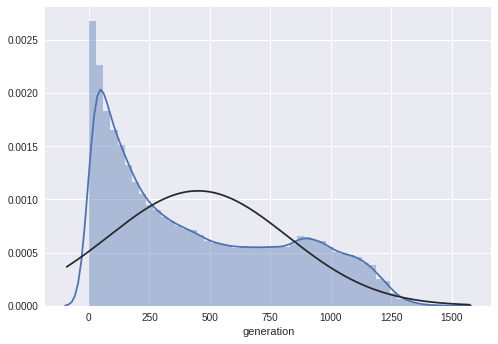

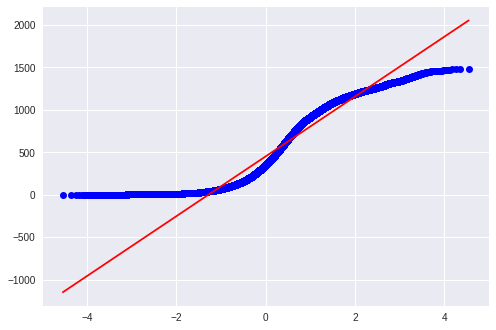

skewness: 0.549233
kurtosis: -0.985330


In [17]:
# kernel density plot
sns.distplot(Y,fit=norm);
plt.ylabel =('Frequency')
plt.title = ('SalePrice Distribution');
#Get the fitted parameters usdata.drop('MEDV',axis=1)ed by the function
(mu, sigma) = norm.fit(Y)
#QQ plot
fig = plt.figure()
res = stats.probplot(Y, plot=plt)
plt.show()
print("skewness: %f" % Y.skew())
print("kurtosis: %f" % Y.kurt())

## Linear-Regression

### Using log transform




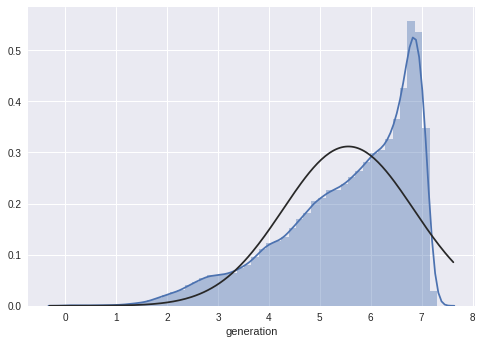

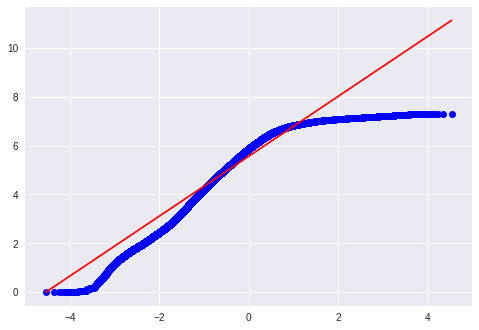

skewness: -0.927941
kurtosis: 0.245403


In [18]:
Y = np.log1p(Y)
# kernel density plot
sns.distplot(Y,fit=norm);
plt.ylabel =('Frequency')
plt.title = ('SalePrice Distribution');
#Get the fitted parameters usdata.drop('MEDV',axis=1)ed by the function
(mu, sigma) = norm.fit(Y)
#QQ plot
fig = plt.figure()
res = stats.probplot(Y, plot=plt)
plt.show()
print("skewness: %f" % Y.skew())
print("kurtosis: %f" % Y.kurt())


In [0]:

from sklearn.linear_model import LinearRegression


In [0]:
#test in a week of year
X_test = X[:-242430] 
X_train = X[-242430:]
y_test = Y[:-242430]
y_train = Y[-242430:]


In [21]:



model = LinearRegression()
model.fit(X_train, y_train)
print("score of model in train data is : {}".format(model.score(X_train, y_train)))
print("score of model in test data is : {}".format(model.score(X_test,y_test)))



score of model in train data is : 0.7074077668770787
score of model in test data is : 0.7339343654431407


### MAPE

In [0]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
predict = model.predict(X_test)
a = mean_absolute_percentage_error(y_test, predict)
print("MAPE of model is : ",a)

MAPE of model is :  10.475369157692755


In [0]:
df = pd.DataFrame()

df['Y_predict'] = predict
df['Y_test'] = y_test.tolist()

In [45]:
df.head()

,Y_predict,Y_test
0,4.332689,2.152924
1,4.332907,2.275214
2,4.333126,2.363680
3,4.333375,2.450143
4,4.333593,2.545531


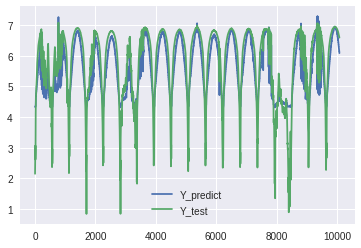

In [43]:
df.plot()

# Random Forest

In [0]:
# Import the model we are using
#from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
#f = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
#rf.fit(X_train[-121215:], y_train[-121215:])